In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13602710471044044145
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5550592606144473966
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
# MAX_VNUM = 20000
SEQUENCE_LENGTH = 300
EMBED_DIMENSION = 100
BATCH_SIZE=64

In [4]:
column_names = ["lemmatized_clean_text", "labels"]
data = pd.read_csv("../Preprocessed_Dataset/ISOT_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[column_names]
train, test = train_test_split(data, test_size=0.2)

In [5]:
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(data[column_names[0]])
vocab_size = len(token.word_index) + 2

In [6]:
embedding_vector = {}
f = open('../data/glove.6B.100d.txt')
# for line in tqdm(f):
#     value = line.split(' ')
#     word = value[0]
#     coef = np.array(value[1:],dtype = 'float32')
#     embedding_vector[word] = coef
for line in tqdm(f):
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embedding_vector[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBED_DIMENSION))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:09, 43853.95it/s]
100%|██████████| 131653/131653 [00:00<00:00, 1796198.41it/s]


### Model

In [16]:
# inputs = keras.Input(shape=(None,), name="input")
# x = layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIMENSION, 
#                      embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
#                      input_length=SEQUENCE_LENGTH, trainable = False)(inputs)
# x = layers.Conv1D(128, 5, activation='relu', use_bias=False, name="Conv1D")(x)
# x = layers.MaxPooling1D(pool_size=2, name="MaxPooling1D")(x)
# x = layers.LSTM(32, activation=None, use_bias=False, name="LSTM")(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model = keras.Model(inputs, outputs)
# model.summary()
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
#     "accuracy",
# ])
model = keras.models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIMENSION, 
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                     input_length=SEQUENCE_LENGTH, trainable = False))
model.add(layers.Permute((2, 1)))
model.add(layers.Conv1D(128, 5, activation='relu', name="Conv1D"))
model.add(layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
model.add(layers.LSTM(32, activation=None, name="LSTM"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[
    "accuracy",
    tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          13165500  
_________________________________________________________________
permute_1 (Permute)          (None, 100, 300)          0         
_________________________________________________________________
Conv1D (Conv1D)              (None, 96, 128)           192128    
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 48, 128)           0         
_________________________________________________________________
LSTM (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,378,269
Trainable params: 212,769
Non-trainable params: 13,165,500
____________________________________

In [8]:
train_x = token.texts_to_sequences(train[column_names[0]])
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")


In [17]:
epochs = 10
history = model.fit(x=train_x, y=train[column_names[1]], validation_split=0.2,
          epochs=epochs, batch_size=BATCH_SIZE)

Epoch 1/10
449/449 [==============================] - 52s 113ms/step - loss: 0.2312 - accuracy: 0.9089 - precision_1: 0.8917 - recall_1: 0.9199 - val_loss: 0.1657 - val_accuracy: 0.9392 - val_precision_1: 0.9298 - val_recall_1: 0.9460
Epoch 2/10
449/449 [==============================] - 50s 111ms/step - loss: 0.1340 - accuracy: 0.9548 - precision_1: 0.9488 - recall_1: 0.9564 - val_loss: 0.1229 - val_accuracy: 0.9581 - val_precision_1: 0.9494 - val_recall_1: 0.9650
Epoch 3/10
449/449 [==============================] - 51s 112ms/step - loss: 0.0648 - accuracy: 0.9774 - precision_1: 0.9779 - recall_1: 0.9744 - val_loss: 0.1104 - val_accuracy: 0.9648 - val_precision_1: 0.9524 - val_recall_1: 0.9762
Epoch 4/10
449/449 [==============================] - 54s 121ms/step - loss: 0.0435 - accuracy: 0.9848 - precision_1: 0.9849 - recall_1: 0.9831 - val_loss: 0.1134 - val_accuracy: 0.9646 - val_precision_1: 0.9565 - val_recall_1: 0.9713
Epoch 5/10
449/449 [==============================] - 55s 12

In [18]:
test_x = token.texts_to_sequences(test[column_names[0]])
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
loss, accuracy, precision, recall = model.evaluate(x=test_x, y=test[column_names[1]])
F1 = 2 * (precision * recall) / (precision + recall)
F1

281/281 [==============================] - 5s 16ms/step - loss: 0.1203 - accuracy: 0.9702 - precision_1: 0.9634 - recall_1: 0.9746


0.9689455510130798

In [19]:
from matplotlib import pyplot as plt

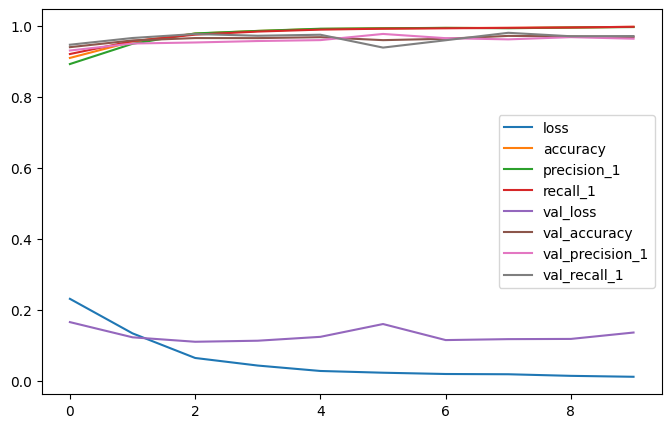

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

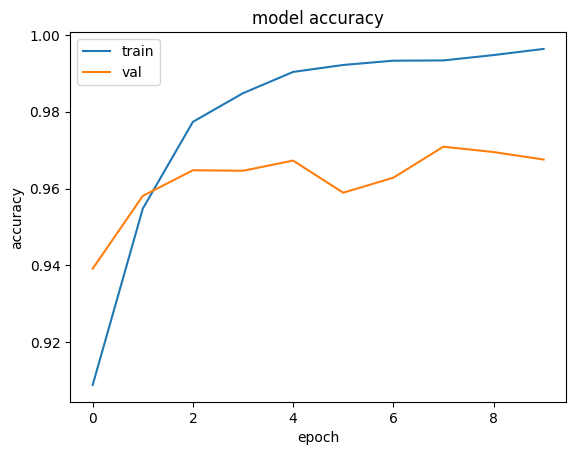

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

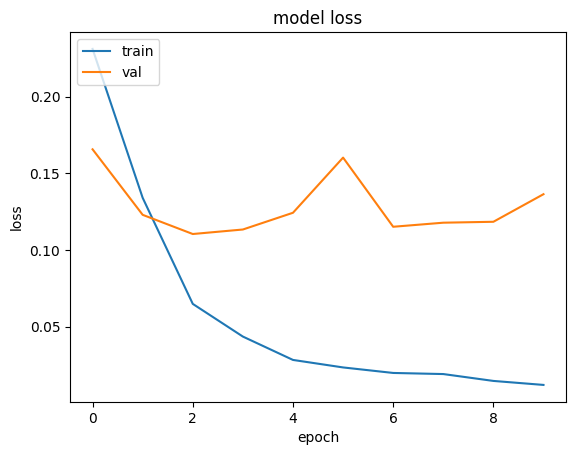

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("Hybrid_ISOT")